In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
import os, shutil, time
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

import keras
from keras.applications.vgg16 import VGG16
from keras import models, layers, optimizers
#from keras.optimizers import Nadam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc ,confusion_matrix, classification_report
import cv2

In [3]:
dir_labels = ['PNEUMONIA', 'NORMAL'] 
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in dir_labels: 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                if label == 'NORMAL':
                    data.append([resized_arr, 0])
                if label == 'PNEUMONIA':
                    if 'virus' in img:
                        data.append([resized_arr, 1])
                    if 'bacteria' in img:
                        data.append([resized_arr, 2])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data('/content/drive/MyDrive/chest_xray/train')
#train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/test')
#test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/val')
#val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
labels = ['Normal', 'Viral','Bacterial']

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


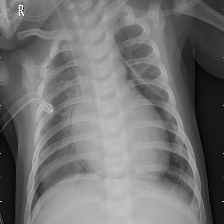

In [6]:
for i in range(1):
    fig = px.imshow(x_train[i], color_continuous_scale='gray', title=labels[y_train[i]])
    fig.show()

In [7]:
# Normalize the data
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [8]:
df_train = pd.DataFrame(y_train)
df_train = pd.DataFrame(df_train.value_counts(), columns=['Train'])
df_val = pd.DataFrame(y_val)
df_val = pd.DataFrame(df_val.value_counts(), columns=['Val'])
df_test = pd.DataFrame(y_test)
df_test = pd.DataFrame(df_test.value_counts(), columns=['Test'])

df_train = df_train.join([df_test, df_val])
df_train = df_train.reset_index().T.drop([0])
df_train.columns = ['Bacterial', 'Viral', 'Normal']

fig = px.bar(df_train)
fig.show()

columns = df_train.columns
index = df_train.index

fig = go.Figure(data=[
    go.Bar(name=index[0], x=columns, y=df_train.iloc[0]),
    go.Bar(name=index[1], x=columns, y=df_train.iloc[1]),
    go.Bar(name=index[2], x=columns, y=df_train.iloc[2])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

columns = df_train.columns
index = df_train.index

fig = go.Figure(data=[
    go.Bar(name=columns[0], x=index, y=df_train.iloc[:,0]),
    go.Bar(name=columns[1], x=index, y=df_train.iloc[:,1]),
    go.Bar(name=columns[2], x=index, y=df_train.iloc[:,2])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [9]:
conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape=(img_size, img_size, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 7

In [12]:
len(model.trainable_weights)

32

In [13]:
conv_base.trainable = True

set_traninable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_traninable = True
    if set_traninable:
        layer.traninable = True
    else:
        layer.trainable = False

len(model.trainable_weights)

12

In [14]:
datagen = ImageDataGenerator(rescale=1./224,
                                  rotation_range=10,
                                  width_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False,
                                  fill_mode='nearest')
datagen.fit(x_train)

In [15]:
time_start = time.process_time()

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',  #optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3)]

history = model.fit(datagen.flow(x_train,y_train, batch_size = 50),
                    steps_per_epoch=100, 
                    epochs=16,
                    validation_data=datagen.flow(x_val, y_val, batch_size = 40),
                    validation_steps=1,
                    callbacks=callbacks_list)


time_end = time.process_time()
print(f'\n\nIt took: {(time_end-time_start)/60} min')

px.line(history.history)

Epoch 1/16
100/100 [==============================] - 84s 669ms/step - loss: 0.9168 - acc: 0.5622 - val_loss: 0.9676 - val_acc: 0.6875 - lr: 0.0100
Epoch 2/16
100/100 [==============================] - 67s 664ms/step - loss: 0.6403 - acc: 0.7135 - val_loss: 0.8774 - val_acc: 0.5625 - lr: 0.0100
Epoch 3/16
100/100 [==============================] - 67s 673ms/step - loss: 0.5860 - acc: 0.7459 - val_loss: 0.9691 - val_acc: 0.6250 - lr: 0.0100
Epoch 4/16
100/100 [==============================] - 67s 663ms/step - loss: 0.5368 - acc: 0.7725 - val_loss: 0.9799 - val_acc: 0.5625 - lr: 0.0100
Epoch 5/16
100/100 [==============================] - 66s 661ms/step - loss: 0.5126 - acc: 0.7836 - val_loss: 1.4898 - val_acc: 0.5000 - lr: 0.0100
Epoch 6/16
100/100 [==============================] - 66s 653ms/step - loss: 0.5037 - acc: 0.7851 - val_loss: 1.0371 - val_acc: 0.5000 - lr: 0.0100
Epoch 7/16
100/100 [==============================] - 63s 629ms/step - loss: 0.4846 - acc: 0.7964 - val_loss: 1.

In [30]:
px.line(history.history['acc'])

In [31]:
px.line(history.history['loss'])

In [32]:
px.line(history.history['val_acc'])

In [33]:
val_loss, val_acc = model.evaluate(x_test, y_test)

20/20 [==============================] - 3s 164ms/step - loss: 11.1079 - acc: 0.7083


In [34]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = 1)

In [35]:
print(classification_report(y_test, y_pred, target_names = labels))

              precision    recall  f1-score   support

      Normal       0.81      0.79      0.80       234
       Viral       0.61      0.37      0.46       148
   Bacterial       0.66      0.84      0.74       242

    accuracy                           0.71       624
   macro avg       0.69      0.67      0.67       624
weighted avg       0.70      0.71      0.70       624



In [36]:
cm = confusion_matrix(y_test, y_pred)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='mint')

fig.update_layout(title_text='<b>Confusion matrix</b>',
                  xaxis = dict(title='Predicted value'),
                  yaxis = dict(title='Real value')
                 )
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show()


In [37]:
y_pred = y_pred.reshape(1,-1)[0]

In [38]:
correct = np.nonzero(y_pred == y_test)[0]
incorrect = np.nonzero(y_pred != y_test)[0]
print(f'Number of incorrect classified images: {len(incorrect)} ~ {round(len(incorrect)/len(y_test)*100,1)}% \nNumber of correct classified images: {len(correct)} ~ {round(len(correct)/len(y_test)*100,1)}%')

correct_normal = np.sum(np.logical_and(y_pred == 0, y_test == 0))
incorrect_normal = np.sum(np.logical_and(y_pred == 0, y_test != 0))
correct_viral = np.sum(np.logical_and(y_pred == 1, y_test == 1))
incorrect_viral = np.sum(np.logical_and(y_pred == 1, y_test != 1))
correct_bac = np.sum(np.logical_and(y_pred == 2, y_test == 2))
incorrect_bac = np.sum(np.logical_and(y_pred == 2, y_test != 2))

print(f'\nNumber of images correctly classified as normal: {correct_normal}')
print(f'Number of images incorrectly classified as normal: {incorrect_normal}')
print(f'Number of images correctly classified as viral: {correct_viral}')
print(f'Number of images incorrectly classified as viral: {incorrect_viral}')
print(f'Number of images correctly classified as bacterial: {correct_bac}')
print(f'Number of images incorrectly classified as bacterial: {incorrect_bac}')

Number of incorrect classified images: 182 ~ 29.2% 
Number of correct classified images: 442 ~ 70.8%

Number of images correctly classified as normal: 184
Number of images incorrectly classified as normal: 44
Number of images correctly classified as viral: 55
Number of images incorrectly classified as viral: 35
Number of images correctly classified as bacterial: 203
Number of images incorrectly classified as bacterial: 103


In [39]:
i=0
for c in incorrect:
    print(y_pred[c])
    print(y_test[c],'\n')
    i += 1
    if i == 4:
        break

2
1 

2
1 

0
2 

0
2 




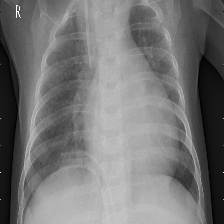


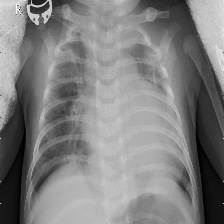

In [40]:
i=0

for c in correct:
    if y_pred[c] == 0: 
        predicted = 'Normal'
    if y_pred[c] == 1: 
        predicted = 'Viral'
    if y_pred[c] == 2: 
        predicted = 'Bacterial'    
    if y_test[c] == 0: 
        GT = 'Normal'
    if y_test[c] == 1: 
        GT = 'Viral'
    if y_test[c] == 2: 
        GT = 'Bacterial'
    fig = px.imshow(x_test[c][:][:][:], title=f'Groundtruth: {GT} <br>Predicted: {predicted}')
    fig.show()
    i += 1
    if i == 2:
        break